# Brief description of the problem and data 

Objective is to build a model that predicts which Tweets are about real disasters and which one’s aren’t.
In data 10,000 tweets were hand classified.

Results are evaluted based on F1 score of the model.

Data is available here : https://www.kaggle.com/competitions/nlp-getting-started/data

Above link contains 3 files:
 * Train file : we use this file to train model
 * Test file : Use this data to test our model
 * Sample submission : This is the format of submission file which we need to upload on kaggle

In train data we have 7613 tweets, to test your model we have 3263 tweets

In [1]:
1+2 

3

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import string
from collections import Counter
import re
from nltk import word_tokenize

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D,BatchNormalization,MaxPool2D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from sklearn.metrics import roc_auc_score
from tensorflow import keras
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.callbacks import EarlyStopping

In [168]:
train_df1 = pd.read_csv(r'/Users/vishalverma/Vishal/Github_project/Twitter-Sentiment-NLP/Data/train.csv')
test_df1 = pd.read_csv(r'/Users/vishalverma/Vishal/Github_project/Twitter-Sentiment-NLP/Data/test.csv')
sample_df1 = pd.read_csv(r'/Users/vishalverma/Vishal/Github_project/Twitter-Sentiment-NLP/Data/sample_submission.csv')

In [4]:
def visual_results(model_1,test_df_x,test_df_y):
    fig,axes = plt.subplots(1,3,figsize = (20,5))
    
    axes[0].plot(model_1.history["loss"], label='Training loss')
    axes[0].plot(model_1.history["val_loss"], label='Validation loss')
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend(frameon=False)
    
    axes[1].plot(model_1.history["accuracy"], label='Training accuracy')
    axes[1].plot(model_1.history["val_accuracy"], label='Validation accuracy')
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].legend(frameon=False)
    
    
    y_pred_keras = model.predict_generator(test_df_x, verbose=1)
    score = model.evaluate(test_df_x, test_df_y, verbose=0)
    
    
    print(f'Test loss: {score[0]} / Test accuracy: {score[1]} / Test Roc : {roc_auc_score(test_df_y,y_pred_keras)}')
    y_classes = list(map(lambda x: 1 if x >= 0.5 else 0,y_pred_keras))
    print('F1 Score : {}'.format(metrics.f1_score(test_df_y,y_classes)))
    
    
    fpr, tpr, _ = metrics.roc_curve(test_df_y,  y_pred_keras)
    
    axes[2].plot(fpr,tpr)
    axes[2].set_ylabel("True Positive Rate")
    axes[2].set_xlabel("False Positive Rate")
    
    #return y_pred_keras

___________

# Exploratory Data Analysis (EDA)

In [5]:
train_df1.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
(train_df1.isna().sum()/train_df1.shape[0])*100

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

As we can see from above table location has 33% missing values

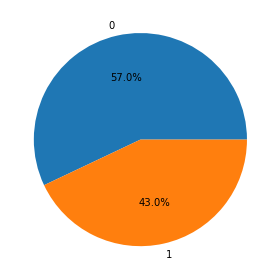

In [8]:
plt.pie(train_df1.target.value_counts(),labels = train_df1.target.value_counts().index,autopct='%.1f%%')
plt.tight_layout()

43% of tweets are categorised as disaster tweet whereas 57% are categorised as non disater tweet.

In [9]:
train_df1.location.value_counts(normalize=True)*100

USA                    2.047244
New York               1.397638
United States          0.984252
London                 0.885827
Canada                 0.570866
                         ...   
MontrÌ©al, QuÌ©bec     0.019685
Montreal               0.019685
ÌÏT: 6.4682,3.18287    0.019685
Live4Heed??            0.019685
Lincoln                0.019685
Name: location, Length: 3341, dtype: float64

In [10]:
positive_tweet = train_df1[train_df1.target == 0]
negative_tweet = train_df1[train_df1.target == 1]

#### Word Cloud

In [11]:
stopwords_ = set(STOPWORDS)

def wordcloudmap(data1,text_col):
    sentences = data1[text_col].tolist()
    sentences_as_one_string = " ".join(sentences)
    plt.figure(figsize=(12,12))
    plt.imshow(WordCloud(collocations=False,
                        background_color='white',
                        stopwords=stopwords_,).generate(sentences_as_one_string))

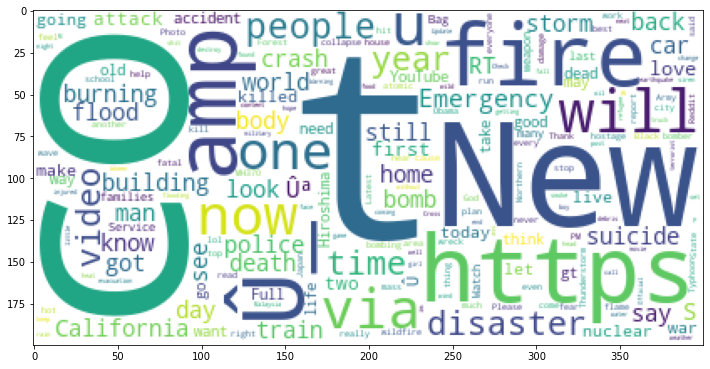

In [12]:
#Word cloud for full data
wordcloudmap(train_df1,'text')

Size of the word defines the frequency count of word

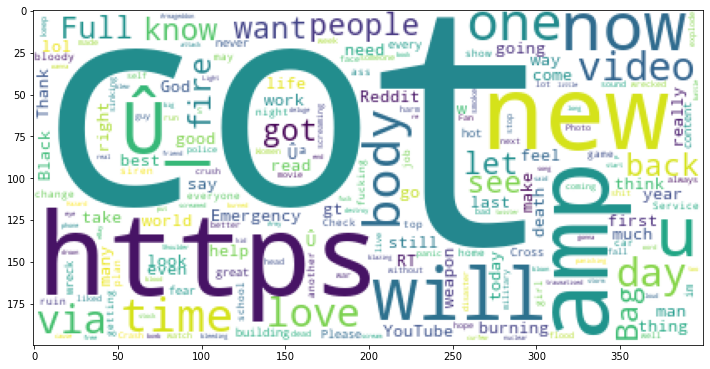

In [13]:
#Word cloud for positive tweet
wordcloudmap(positive_tweet,'text')

We can see some keywords like : will, body,time,new,now,full, love,amp etc

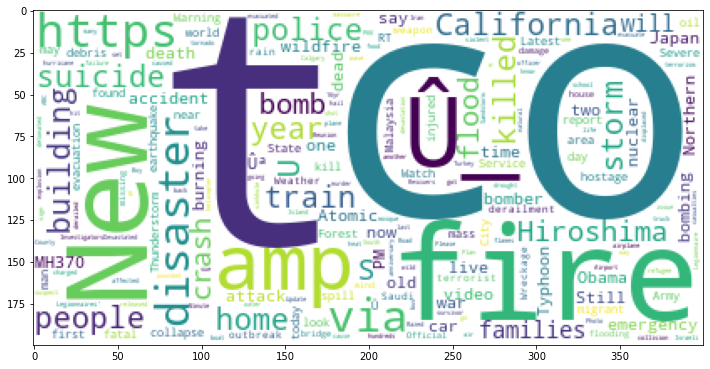

In [14]:
#Word cloud for negative tweet
wordcloudmap(negative_tweet,'text')

Here we can see keywords like : New, fire, Hiroshima, flood,death, suicide bomber, storm etc

With these word clouds we can see a significant difference in words for both tweet which are for disaster and which are not for disaster

In [15]:
# word_count
train_df1['word_count'] = train_df1['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_df1['unique_word_count'] = train_df1['text'].apply(lambda x: len(set(str(x).split())))

# url_count
train_df1['url_count'] = train_df1['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train_df1['mean_word_length'] = train_df1['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# punctuation_count
train_df1['punctuation_count'] = train_df1['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train_df1['hashtag_count'] = train_df1['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train_df1['mention_count'] = train_df1['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

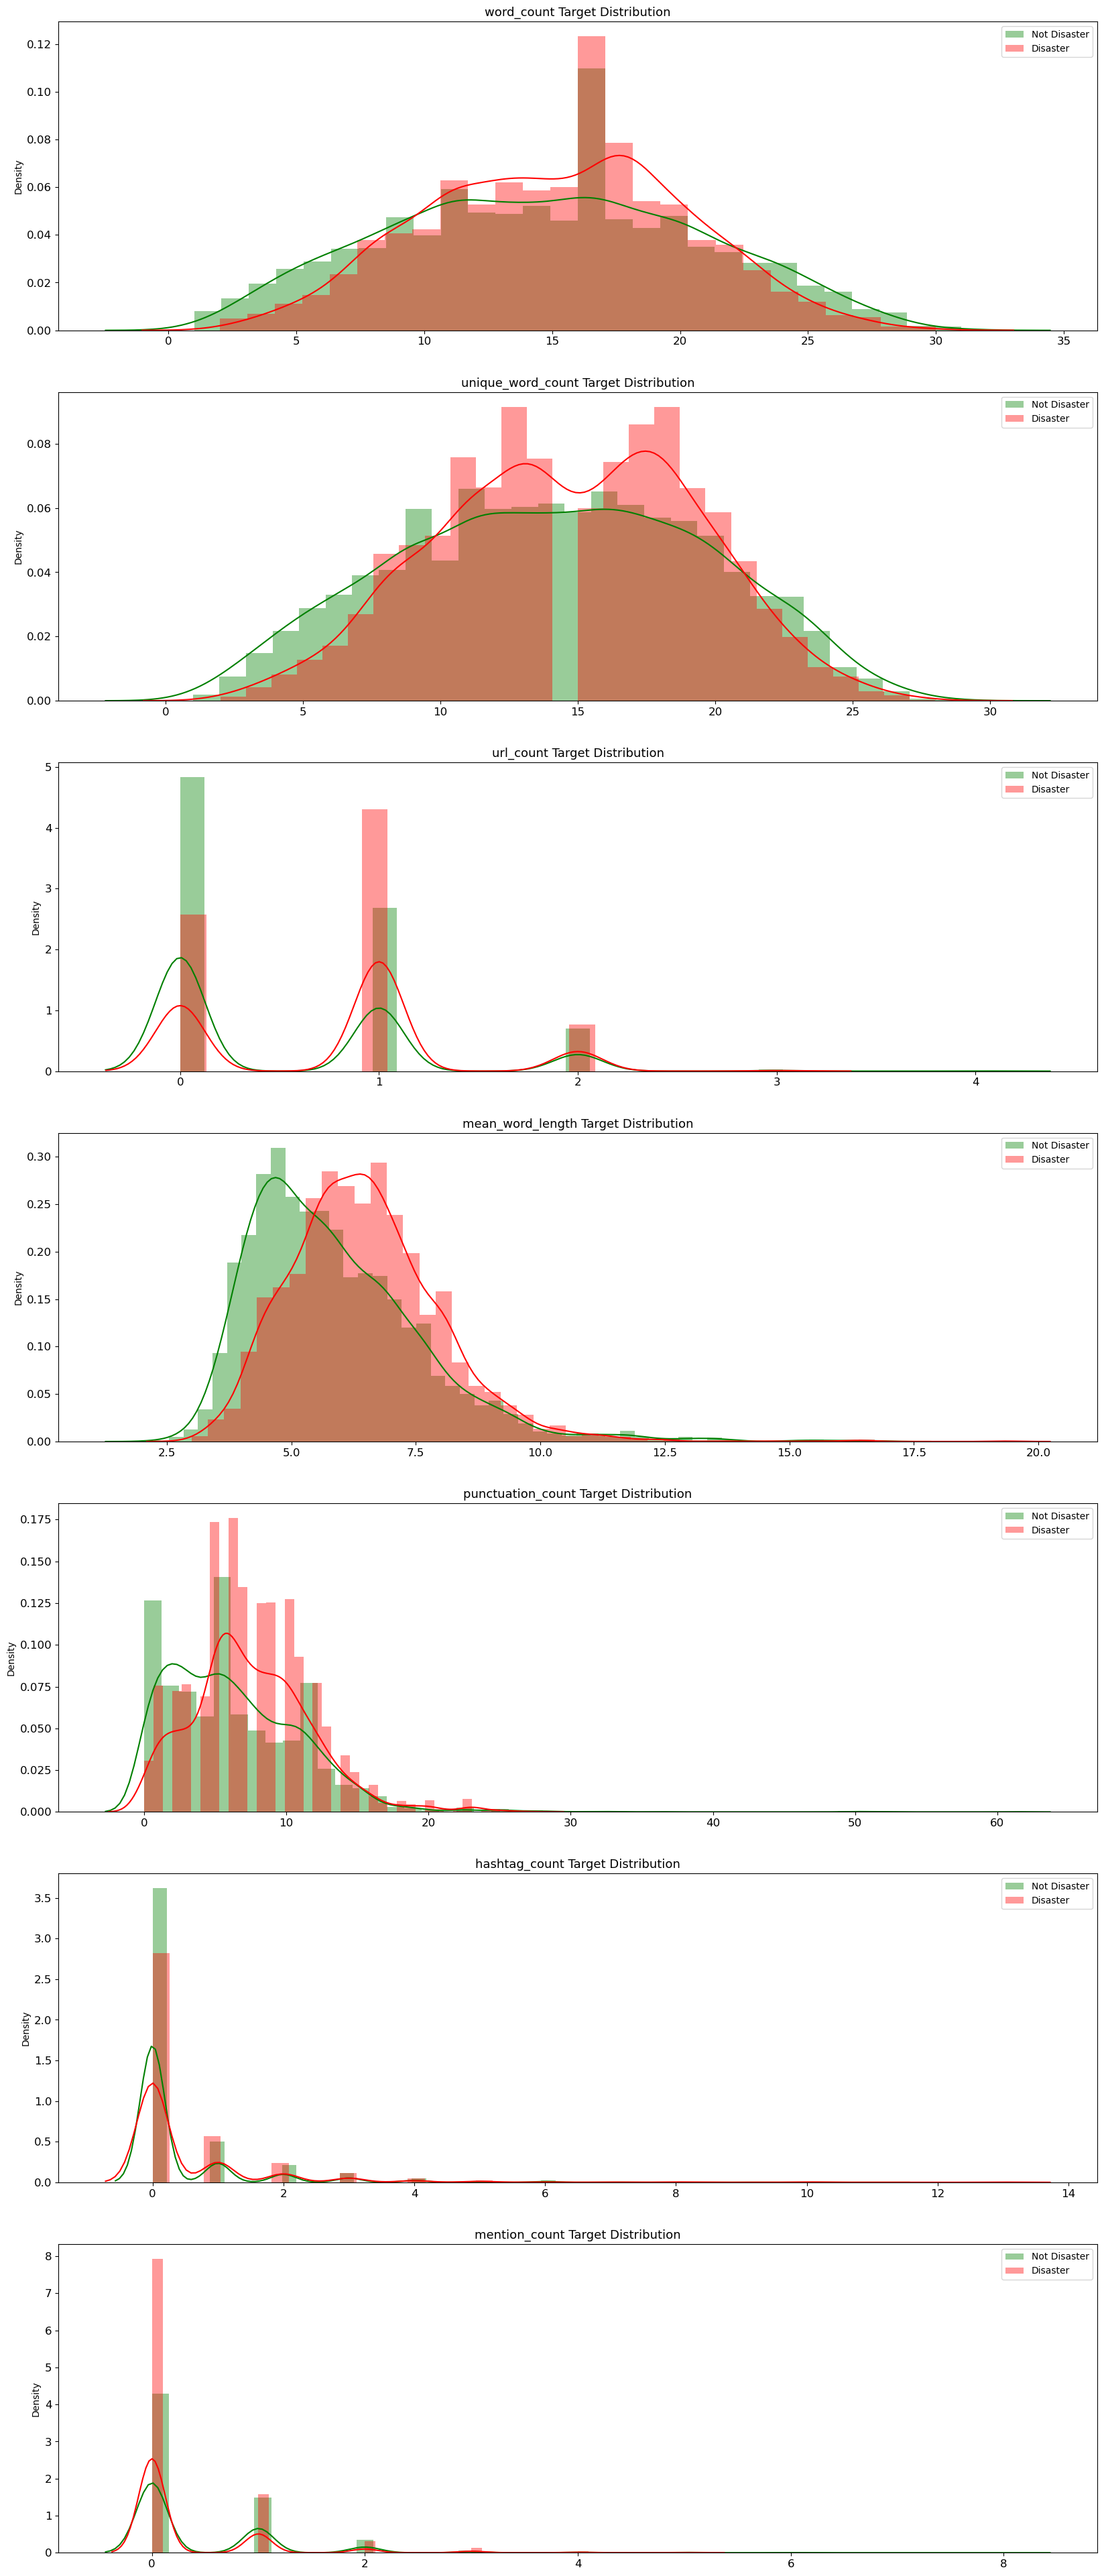

In [16]:
import warnings
warnings.filterwarnings('ignore')

METAFEATURES = ['word_count', 'unique_word_count', 'url_count', 'mean_word_length',
                'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = train_df1['target'] == 1

fig, axes = plt.subplots(ncols=1, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_df1.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i], color='green')
    sns.distplot(train_df1.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i], color='red')
    
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].legend()
    
    axes[i].set_title(f'{feature} Target Distribution', fontsize=13)

plt.show()

Based on the above charts we can infer that there is a difference in the distribution of diaster and non disaster tweets.

### N-Grams

In [17]:
class generate_ngrams():
    def __init__(self,text,n_gram):
        self.text = text
        self.n_gram = n_gram
        self.out = []
        #self.n_tweet = num_of_tweet
        #self.df = data1
        
    def creating_ngram(self,tweet1):

        token = [token for token in tweet1.lower().split(' ') if token != '' if token not in STOPWORDS]
        ngrams = zip(*[token[i:] for i in range(self.n_gram)])
        out1 = [' '.join(ngram) for ngram in ngrams]
        return out1
    
    def ngrams_out(self):
        
        for i in self.text:
            
            self.out += self.creating_ngram(i)
            
        return self.out

In [18]:
def ngramchart(n,diaster,nondiaster):
    fig,axes = plt.subplots(nrows = 1,ncols=2,figsize=(20, 5), dpi=100)
    sns.barplot(y=diaster[0][:n],x=diaster[1][:n],ax=axes[0],color='red')
    axes[0].set_title('Top {} Disaster unigram'.format(n))
    sns.barplot(y=nondiaster[0][:n],x=nondiaster[1][:n],ax=axes[1],color='green')
    axes[1].set_title('Top {} Non Disaster unigram'.format(n))

In [19]:
###Disaster tweet

d_unigram = Counter(generate_ngrams(train_df1[DISASTER_TWEETS].text,1).ngrams_out())
d_bigram = Counter(generate_ngrams(train_df1[DISASTER_TWEETS].text,2).ngrams_out())
d_trigram = Counter(generate_ngrams(train_df1[DISASTER_TWEETS].text,3).ngrams_out())

###Non diaster tweet
nd_unigram = Counter(generate_ngrams(train_df1[~DISASTER_TWEETS].text,1).ngrams_out())
nd_bigram = Counter(generate_ngrams(train_df1[~DISASTER_TWEETS].text,2).ngrams_out())
nd_trigram = Counter(generate_ngrams(train_df1[~DISASTER_TWEETS].text,3).ngrams_out())

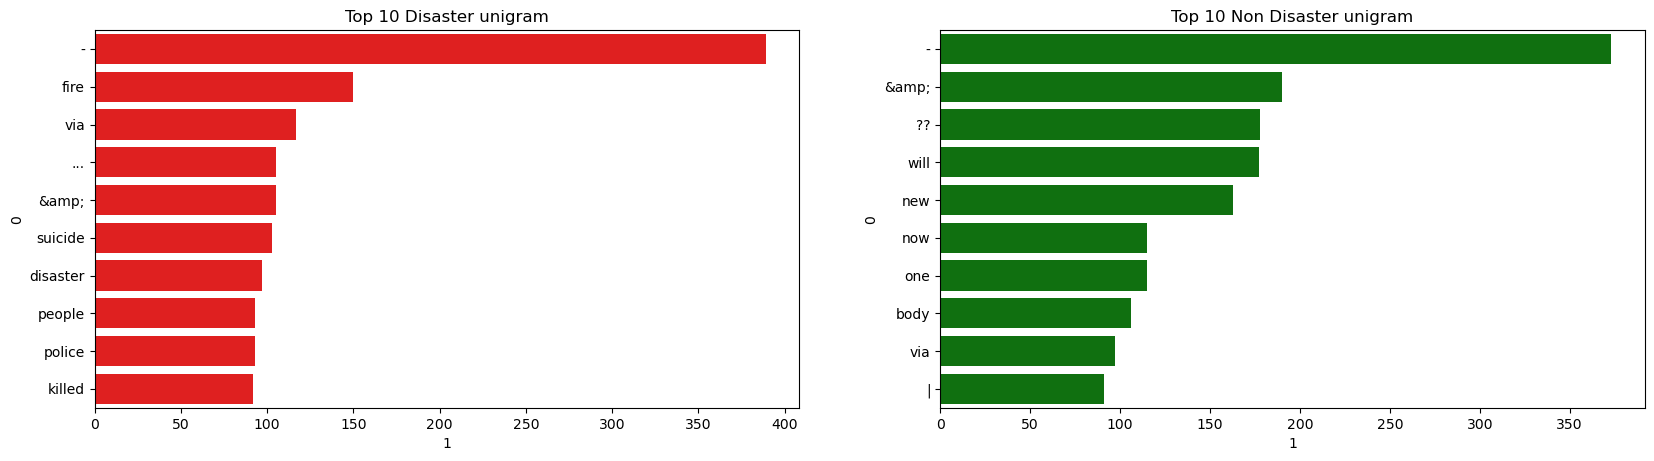

In [20]:
df_disaster_unigrams = pd.DataFrame(sorted(d_unigram.items(), key=lambda x: x[1])).sort_values(1,ascending=False)
df_nondisaster_unigrams = pd.DataFrame(sorted(nd_unigram.items(), key=lambda x: x[1])).sort_values(1,ascending=False)

ngramchart(10,df_disaster_unigrams,df_nondisaster_unigrams)

Most common unigrams in disaster tweets are already giving information about disasters. It is very hard to use some of those words in other contexts.

Most common unigrams in non-disaster tweets are verbs.

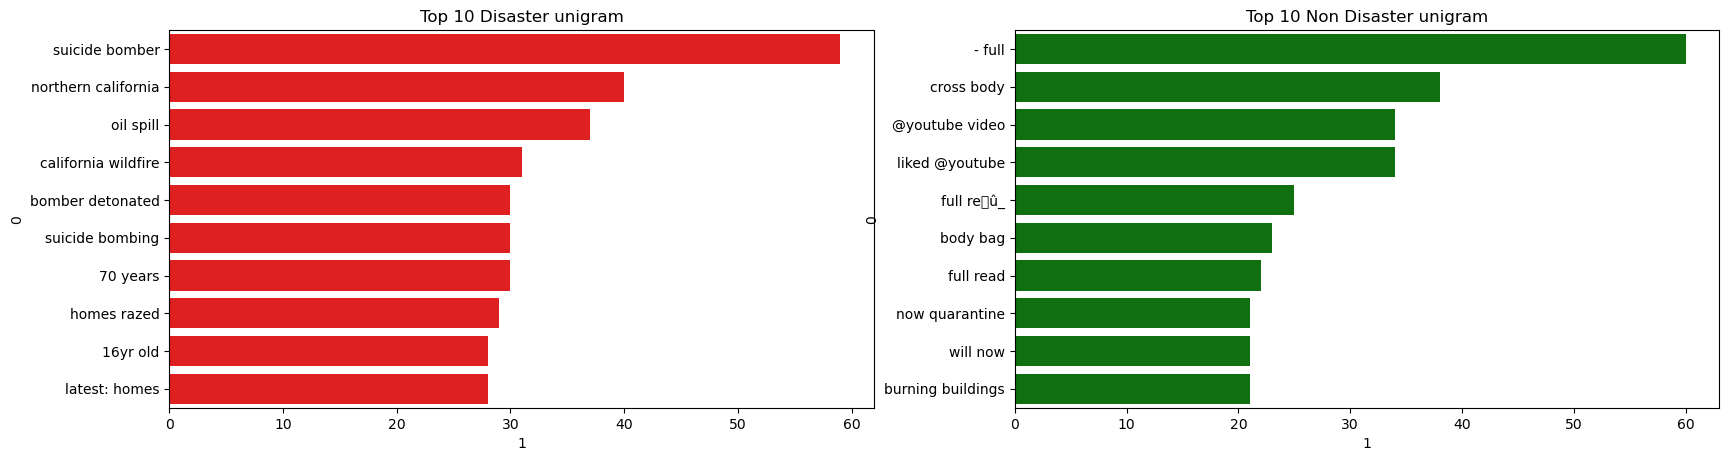

In [21]:
df_disaster_bigrams = pd.DataFrame(sorted(d_bigram.items(), key=lambda x: x[1])).sort_values(1,ascending=False)
df_nondisaster_bigrams = pd.DataFrame(sorted(nd_bigram.items(), key=lambda x: x[1])).sort_values(1,ascending=False)

ngramchart(10,df_disaster_bigrams,df_nondisaster_bigrams)

There are no common bigrams exist in both classes because the context is clearer.

Most common bigrams in disaster tweets are giving more information about the disasters than unigrams, but punctuations have to be stripped from words.

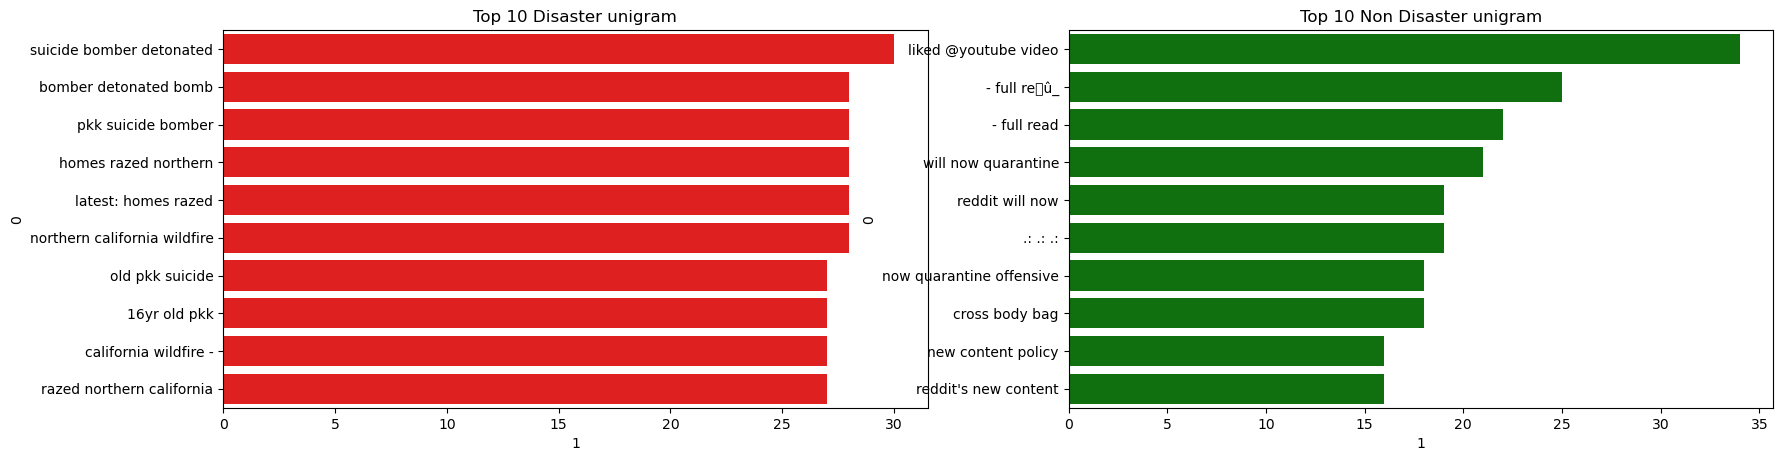

In [22]:
df_disaster_trigrams = pd.DataFrame(sorted(d_trigram.items(), key=lambda x: x[1])).sort_values(1,ascending=False)
df_nondisaster_trigrams = pd.DataFrame(sorted(nd_trigram.items(), key=lambda x: x[1])).sort_values(1,ascending=False)

ngramchart(10,df_disaster_trigrams,df_nondisaster_trigrams)

There are no common trigrams exist in both classes because the context is clearer.

Most common trigrams in disaster tweets are very similar to bigrams. They give lots of information about disasters, but they may not provide any additional information along with bigrams.

### Data Cleaning

In Data Cleaning we will do following steps:
* Removing Punctuations
* Removing URLs
* Removing Stopwords
* Lemmanization


In [23]:
import string
string.punctuation

from nltk.corpus import stopwords
from nltk.corpus import wordnet

from nltk.stem import WordNetLemmatizer
lem=WordNetLemmatizer()

In [24]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
def remove_html(in_str):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', in_str)
def hastag_removed(in_str2):
    hastag_pattern = re.compile('#[A-Za-z0-9_]+')
    return hastag_pattern.sub(r'',in_str2)

In [25]:
def cleaning_text(msg1):
    
    ## removing punctuations
    punc_removed = [char for char in msg1 if char not in string.punctuation]
    punc_removed2 = ''.join(punc_removed)
    
    ## remove stop words
    stop_word_removed1 = [word.lower() for word in punc_removed2.split() if word.lower() not in stopwords.words('english')]
    
    stop_word_removed1 = ' '.join(stop_word_removed1)
    
    return stop_word_removed1

In [26]:
def do_lemmatizing(in_str):
    #new_str=""
    new_str = []
    for word in in_str.split():
        #new_str=new_str + lem.lemmatize(word) + " "
        new_str.append(lem.lemmatize(word))
    
    new_str = ' '.join(new_str)
    return new_str


In [27]:
train_df1['type'] = 'train'
test_df1['type'] = 'test'

df1 = pd.concat([train_df1,test_df1],axis = 0).reset_index()

In [28]:
df1["urls_removed"]= df1["text"].apply(lambda x: remove_urls(x))
df1["html_removed"]=df1["urls_removed"].apply(lambda x: remove_html(x))
df1['hastag_removed'] = df1["html_removed"].apply(lambda x: hastag_removed(x))

In [29]:
df1['cleaned_text'] = df1.hastag_removed.apply(cleaning_text)

In [30]:
df1['cleaned_text2'] = df1.cleaned_text.apply(do_lemmatizing)

In [31]:
# use keras to create a Tokenizer object
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(df1['cleaned_text2']))


###dividing data into test and train
train_df2 = df1[df1.type == 'train']
test_df2 = df1[df1.type == 'test']

tokenized_texts = tokenizer.texts_to_sequences(train_df2['cleaned_text2'])

In [32]:
print('Maximum word length : {}'.format(df1['cleaned_text2'].apply(lambda x: len(str(x).split())).max()))

Maximum word length : 25


#### TF_IDF transformation

In [33]:
from sklearn import feature_extraction

In [34]:
tfidf_vectorizer = feature_extraction.text.TfidfVectorizer()
text_df1 = tfidf_vectorizer.fit(df1.cleaned_text2)

In [35]:
tfidf_train_x = text_df1.transform(train_df2.cleaned_text2)
tfidf_test_x = text_df1.transform(test_df2.cleaned_text2)

In [39]:
from sklearn.model_selection import train_test_split

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_train_x, train_df2.target, test_size=0.2)

#### Tokenization

In [40]:
train_X = sequence.pad_sequences(tokenized_texts, maxlen=25)
final_test_X = sequence.pad_sequences(tokenizer.texts_to_sequences(test_df2['cleaned_text2']), maxlen=25)

train_y = train_df2.target
final_test_y = test_df2.target

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2)

In [42]:
all_words = []

text1 = df1.cleaned_text2.apply(lambda x : x.split(' '))

for i in text1:
    all_words += i

    
all_words2 = set(all_words)

# Model Architecture

### Model - 1

We will start with baseline Neural Network Model.

In [48]:
# Hyper parameters
dense_layer1 = 1024
dense_layer2 = 1024

optimizer = 'adam'

batch_size = 256
epochs = 20




# define the model
model = Sequential()
model.add(Dense(dense_layer1, input_dim=X_train_tfidf.shape[1]))
model.add(Activation('relu'))

model.add(Dense(dense_layer2))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', patience=5)


base_model = model.fit(X_train_tfidf.todense(),y_train_tfidf.values, batch_size=batch_size, epochs=epochs,
                       validation_split=0.1,callbacks=[es])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1024)              19559424  
                                                                 
 activation_6 (Activation)   (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 1024)              1049600   
                                                                 
 activation_7 (Activation)   (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 1)                 1025      
                                                                 
 activation_8 (Activation)   (None, 1)                 0         
                                                                 
Total params: 20,610,049
Trainable params: 20,610,049


2022-06-05 22:00:12.694436: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-05 22:00:12.975524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 2s 50ms/step - loss: 0.6147 - accuracy: 0.6543 - val_loss: 0.4751 - val_accuracy: 0.8030
Epoch 2/20
 3/22 [===>..........................] - ETA: 0s - loss: 0.2877 - accuracy: 0.9180

2022-06-05 22:00:14.188465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 1s 40ms/step - loss: 0.2399 - accuracy: 0.9172 - val_loss: 0.5430 - val_accuracy: 0.7800
Epoch 3/20
22/22 [==============================] - 1s 38ms/step - loss: 0.0844 - accuracy: 0.9743 - val_loss: 0.6293 - val_accuracy: 0.7422
Epoch 4/20
22/22 [==============================] - 1s 37ms/step - loss: 0.0500 - accuracy: 0.9794 - val_loss: 0.6721 - val_accuracy: 0.7521
Epoch 5/20
22/22 [==============================] - 1s 37ms/step - loss: 0.0459 - accuracy: 0.9808 - val_loss: 0.7182 - val_accuracy: 0.7356
Epoch 6/20
22/22 [==============================] - 1s 37ms/step - loss: 0.0396 - accuracy: 0.9818 - val_loss: 0.6923 - val_accuracy: 0.7619


28/48 [================>.............] - ETA: 0s

2022-06-05 22:00:20.914581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 0s 7ms/step


2022-06-05 22:00:21.399742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.7375957369804382 / Test accuracy: 0.7478660941123962 / Test Roc : 0.8239784475393028
F1 Score : 0.7


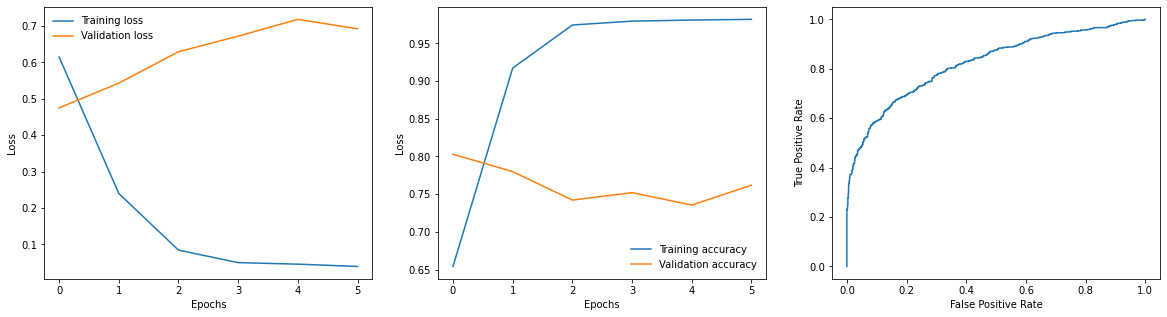

In [49]:
visual_results(base_model,X_test_tfidf.todense(),y_test_tfidf)

In our base model we got F1 score of 0.7

### Model - 2

Here we will try simple RNN model

In [ ]:
X_train, X_test, y_train, y_test

In [52]:
# Hyper parameters
dense_layer1 = 1024
dense_layer2 = 1024

optimizer = 'adam'

batch_size = 256
epochs = 20


model = Sequential()
model.add(Embedding(len(all_words2),100,input_length=25))
model.add(LSTM(100))

model.add(Dense(1024))
model.add(Activation('relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', patience=5)


base_model = model.fit(X_train,y_train.values, batch_size=batch_size, epochs=epochs,
                       validation_split=0.1,callbacks=[es])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 100)           1941300   
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_11 (Dense)            (None, 1024)              103424    
                                                                 
 activation_10 (Activation)  (None, 1024)              0         
                                                                 
 dense_12 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 2,126,149
Trainable params: 2,126,149
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20


2022-06-05 22:02:29.294601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 22:02:29.478970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 22:02:29.836420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 3s 73ms/step - loss: 0.6654 - accuracy: 0.5939 - val_loss: 0.5979 - val_accuracy: 0.7323
Epoch 2/20


2022-06-05 22:02:31.478312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 22:02:31.531910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 1s 37ms/step - loss: 0.4114 - accuracy: 0.8411 - val_loss: 0.4945 - val_accuracy: 0.7882
Epoch 3/20
22/22 [==============================] - 1s 36ms/step - loss: 0.2058 - accuracy: 0.9212 - val_loss: 0.5411 - val_accuracy: 0.8013
Epoch 4/20
22/22 [==============================] - 1s 36ms/step - loss: 0.1073 - accuracy: 0.9646 - val_loss: 0.7372 - val_accuracy: 0.7833
Epoch 5/20
22/22 [==============================] - 1s 39ms/step - loss: 0.0738 - accuracy: 0.9746 - val_loss: 0.7436 - val_accuracy: 0.7586
Epoch 6/20
22/22 [==============================] - 1s 36ms/step - loss: 0.0634 - accuracy: 0.9785 - val_loss: 0.7925 - val_accuracy: 0.7422
Epoch 7/20
22/22 [==============================] - 1s 37ms/step - loss: 0.0617 - accuracy: 0.9794 - val_loss: 0.8000 - val_accuracy: 0.7718


15/48 [========>.....................] - ETA: 0s

2022-06-05 22:03:50.809523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 22:03:50.850468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 1s 8ms/step
Test loss: 0.8996340036392212 / Test accuracy: 0.7426132559776306 / Test Roc : 0.805983083012909
F1 Score : 0.6951788491446346


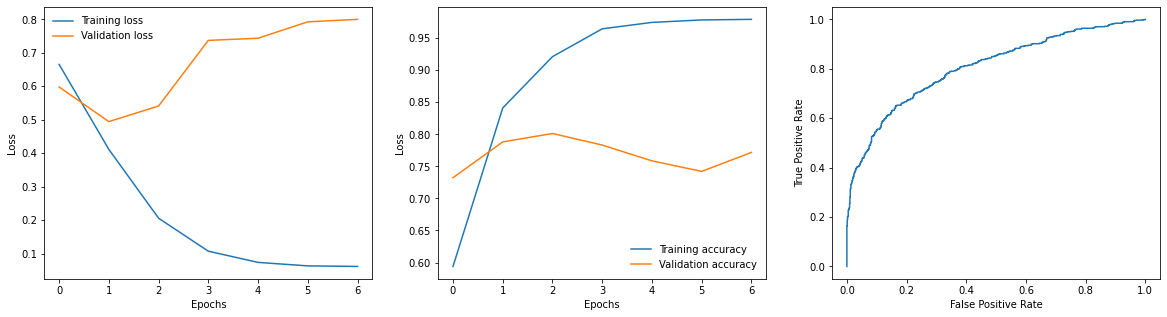

In [54]:
visual_results(base_model,X_test,y_test.values)

F1 score of RNN model is similar to previous model

### Model - 3

adding dropout to model

In [65]:
# Hyper parameters
dense_layer1 = 500
dropoutval = 0.5

optimizer = 'adam'

batch_size = 100
epochs = 20


model = Sequential()
model.add(Embedding(len(all_words2),100,input_length=25))
model.add(LSTM(100))

model.add(Dense(dense_layer1))
model.add(Activation('relu'))
model.add(Dropout(dropoutval))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', patience=5)


base_model = model.fit(X_train,y_train.values, batch_size=batch_size, epochs=epochs,
                       validation_split=0.1,callbacks=[es])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 25, 100)           1941300   
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                                 
 dense_24 (Dense)            (None, 500)               50500     
                                                                 
 activation_17 (Activation)  (None, 500)               0         
                                                                 
 dropout_4 (Dropout)         (None, 500)               0         
                                                                 
 dense_25 (Dense)            (None, 1)                 501       
                                                                 
Total params: 2,072,701
Trainable params: 2,072,701
N

2022-06-05 22:11:14.313974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 22:11:14.472491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 2/55 [>.............................] - ETA: 2s - loss: 0.6917 - accuracy: 0.5850  

2022-06-05 22:11:14.609611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - ETA: 0s - loss: 0.6203 - accuracy: 0.6464

2022-06-05 22:11:16.364956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 22:11:16.429152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 4s 35ms/step - loss: 0.6203 - accuracy: 0.6464 - val_loss: 0.4618 - val_accuracy: 0.7947
Epoch 2/20
55/55 [==============================] - 1s 23ms/step - loss: 0.3143 - accuracy: 0.8730 - val_loss: 0.4942 - val_accuracy: 0.7783
Epoch 3/20
55/55 [==============================] - 1s 23ms/step - loss: 0.1617 - accuracy: 0.9392 - val_loss: 0.5591 - val_accuracy: 0.7849
Epoch 4/20
55/55 [==============================] - 1s 23ms/step - loss: 0.1048 - accuracy: 0.9659 - val_loss: 0.7314 - val_accuracy: 0.7767
Epoch 5/20
55/55 [==============================] - 1s 23ms/step - loss: 0.0787 - accuracy: 0.9726 - val_loss: 0.7686 - val_accuracy: 0.7816
Epoch 6/20
55/55 [==============================] - 1s 23ms/step - loss: 0.0633 - accuracy: 0.9779 - val_loss: 0.7471 - val_accuracy: 0.7800


 9/48 [====>.........................] - ETA: 0s 

2022-06-05 22:11:23.110770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 22:11:23.151777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 1s 7ms/step
Test loss: 0.8087982535362244 / Test accuracy: 0.7485226392745972 / Test Roc : 0.8091289061670172
F1 Score : 0.6908797417271993


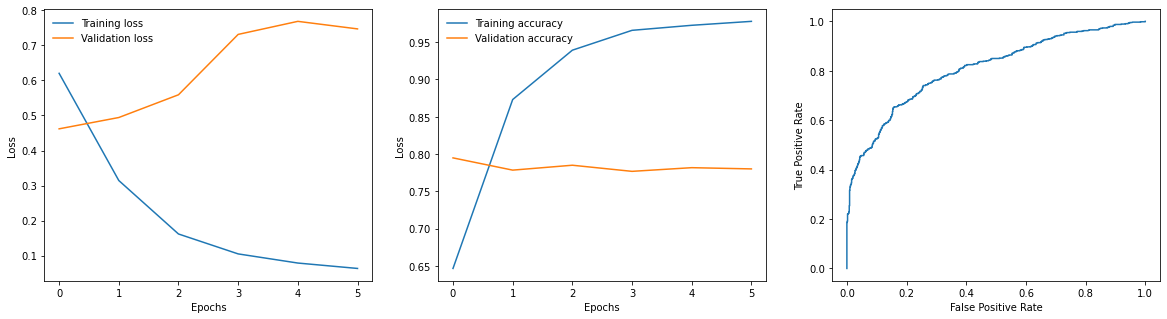

In [66]:
visual_results(base_model,X_test,y_test.values)

added dense layer hasn't made much changes in F1 score

### Model - 4

adding more layer

In [69]:
# Hyper parameters
dense_layer1 = 1024
dropoutval = 0.1

optimizer = 'adam'

batch_size = 100
epochs = 20


model = Sequential()
model.add(Embedding(len(all_words2),100,input_length=25))
model.add(LSTM(128))
model.add(Activation('relu'))

model.add(Dense(dense_layer1))
model.add(Activation('relu'))
model.add(Dropout(dropoutval))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', patience=5)


base_model = model.fit(X_train,y_train.values, batch_size=batch_size, epochs=epochs,
                       validation_split=0.1,callbacks=[es])

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 25, 100)           1941300   
                                                                 
 lstm_9 (LSTM)               (None, 128)               117248    
                                                                 
 activation_19 (Activation)  (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 1024)              132096    
                                                                 
 activation_20 (Activation)  (None, 1024)              0         
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_29 (Dense)            (None, 1)               

2022-06-05 22:13:43.546858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 22:13:43.722552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/55 [..............................] - ETA: 1:40 - loss: 0.6928 - accuracy: 0.6100

2022-06-05 22:13:43.906203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - ETA: 0s - loss: 0.6173 - accuracy: 0.6499

2022-06-05 22:13:45.758130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 22:13:45.825261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 4s 39ms/step - loss: 0.6173 - accuracy: 0.6499 - val_loss: 0.4472 - val_accuracy: 0.7980
Epoch 2/20
55/55 [==============================] - 1s 26ms/step - loss: 0.3133 - accuracy: 0.8719 - val_loss: 0.4589 - val_accuracy: 0.7964
Epoch 3/20
55/55 [==============================] - 1s 24ms/step - loss: 0.1633 - accuracy: 0.9433 - val_loss: 0.5823 - val_accuracy: 0.7800
Epoch 4/20
55/55 [==============================] - 1s 23ms/step - loss: 0.1007 - accuracy: 0.9670 - val_loss: 0.6906 - val_accuracy: 0.7718
Epoch 5/20
55/55 [==============================] - 1s 24ms/step - loss: 0.0738 - accuracy: 0.9745 - val_loss: 0.7385 - val_accuracy: 0.7833
Epoch 6/20
55/55 [==============================] - 1s 24ms/step - loss: 0.0642 - accuracy: 0.9790 - val_loss: 0.7569 - val_accuracy: 0.7734


 1/48 [..............................] - ETA: 13s

2022-06-05 22:13:53.043847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 22:13:53.086759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 1s 6ms/step
Test loss: 0.8629340529441833 / Test accuracy: 0.7327643036842346 / Test Roc : 0.8090244584652208
F1 Score : 0.6909643128321944


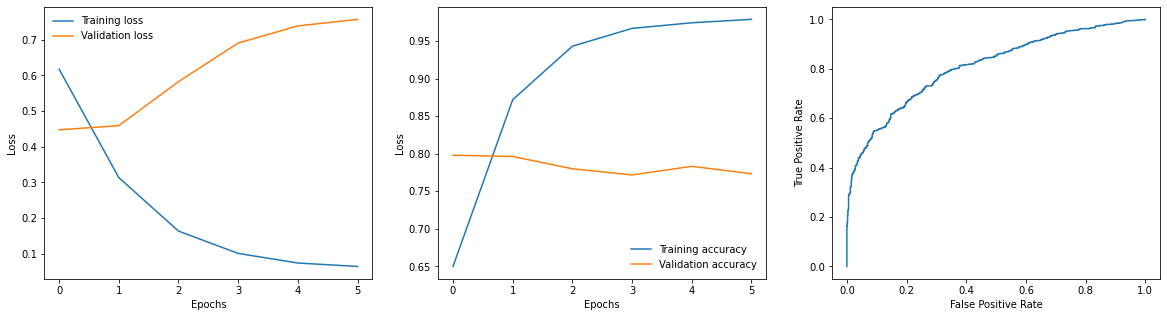

In [70]:
visual_results(base_model,X_test,y_test.values)

# Hyper parameter optimization

Changing optimizer to SGD

### Model - 5

In [73]:
# Hyper parameters
dense_layer1 = 1024
dropoutval = 0.1

optimizer = keras.optimizers.SGD()

batch_size = 250
epochs = 20


model = Sequential()
model.add(Embedding(len(all_words2),100,input_length=25))
model.add(LSTM(128))
model.add(Activation('relu'))

model.add(Dense(dense_layer1))
model.add(Activation('relu'))
model.add(Dropout(dropoutval))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', patience=5)


base_model = model.fit(X_train,y_train.values, batch_size=batch_size, epochs=epochs,
                       validation_split=0.1,callbacks=[es])

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 25, 100)           1941300   
                                                                 
 lstm_11 (LSTM)              (None, 128)               117248    
                                                                 
 activation_23 (Activation)  (None, 128)               0         
                                                                 
 dense_32 (Dense)            (None, 1024)              132096    
                                                                 
 activation_24 (Activation)  (None, 1024)              0         
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_33 (Dense)            (None, 1)               

2022-06-05 22:26:55.109012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 22:26:55.258425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 22:26:55.481081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - ETA: 0s - loss: 0.6923 - accuracy: 0.5650

2022-06-05 22:26:56.771296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 22:26:56.831499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 3s 61ms/step - loss: 0.6923 - accuracy: 0.5650 - val_loss: 0.6912 - val_accuracy: 0.5764
Epoch 2/20
22/22 [==============================] - 1s 30ms/step - loss: 0.6909 - accuracy: 0.5669 - val_loss: 0.6897 - val_accuracy: 0.5764
Epoch 3/20
22/22 [==============================] - 1s 30ms/step - loss: 0.6897 - accuracy: 0.5669 - val_loss: 0.6884 - val_accuracy: 0.5764
Epoch 4/20
22/22 [==============================] - 1s 30ms/step - loss: 0.6887 - accuracy: 0.5669 - val_loss: 0.6874 - val_accuracy: 0.5764
Epoch 5/20
22/22 [==============================] - 1s 30ms/step - loss: 0.6878 - accuracy: 0.5669 - val_loss: 0.6864 - val_accuracy: 0.5764
Epoch 6/20
22/22 [==============================] - 1s 31ms/step - loss: 0.6871 - accuracy: 0.5669 - val_loss: 0.6857 - val_accuracy: 0.5764
Epoch 7/20
22/22 [==============================] - 1s 30ms/step - loss: 0.6866 - accuracy: 0.5669 - val_loss: 0.6850 - val_accuracy: 0.5764
Epoch 8/20
22/22 [======

10/48 [=====>........................] - ETA: 0s 

2022-06-05 22:27:09.886527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 22:27:09.930817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 1s 7ms/step
Test loss: 0.6807206869125366 / Test accuracy: 0.5804333686828613 / Test Roc : 0.6151394288303982
F1 Score : 0.0


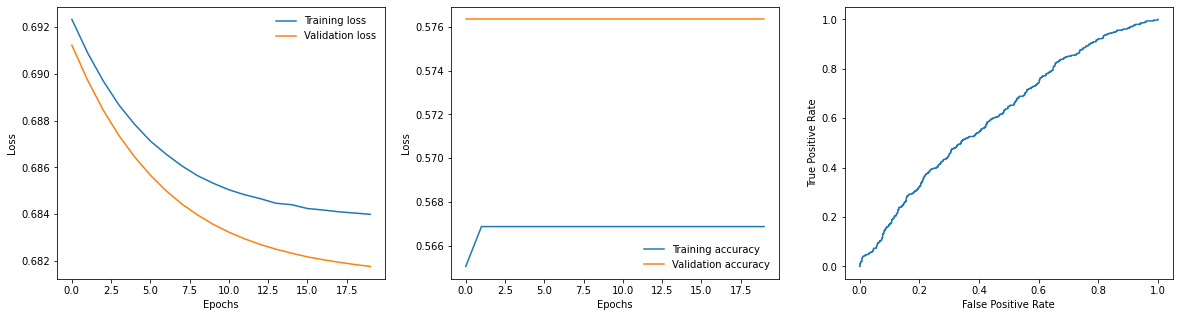

In [74]:
visual_results(base_model,X_test,y_test.values)

### Model - 6

adding learning rate scheduler

In [76]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

In [77]:
# Hyper parameters
dense_layer1 = 1024
dropoutval = 0.1

optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

batch_size = 250
epochs = 20


model = Sequential()
model.add(Embedding(len(all_words2),100,input_length=25))
model.add(LSTM(128))
model.add(Activation('relu'))

model.add(Dense(dense_layer1))
model.add(Activation('relu'))
model.add(Dropout(dropoutval))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', patience=5)


base_model = model.fit(X_train,y_train.values, batch_size=batch_size, epochs=epochs,
                       validation_split=0.1,callbacks=[es])

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 25, 100)           1941300   
                                                                 
 lstm_12 (LSTM)              (None, 128)               117248    
                                                                 
 activation_25 (Activation)  (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 1024)              132096    
                                                                 
 activation_26 (Activation)  (None, 1024)              0         
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0         
                                                                 
 dense_35 (Dense)            (None, 1)               

2022-06-05 22:29:32.724070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 22:29:32.916787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/22 [>.............................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5560

2022-06-05 22:29:33.055224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.5665

2022-06-05 22:29:34.205089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 22:29:34.268682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 2s 61ms/step - loss: 0.6921 - accuracy: 0.5665 - val_loss: 0.6910 - val_accuracy: 0.5764
Epoch 2/20
22/22 [==============================] - 1s 31ms/step - loss: 0.6907 - accuracy: 0.5669 - val_loss: 0.6895 - val_accuracy: 0.5764
Epoch 3/20
22/22 [==============================] - 1s 31ms/step - loss: 0.6894 - accuracy: 0.5669 - val_loss: 0.6881 - val_accuracy: 0.5764
Epoch 4/20
22/22 [==============================] - 1s 31ms/step - loss: 0.6884 - accuracy: 0.5669 - val_loss: 0.6871 - val_accuracy: 0.5764
Epoch 5/20
22/22 [==============================] - 1s 31ms/step - loss: 0.6876 - accuracy: 0.5669 - val_loss: 0.6861 - val_accuracy: 0.5764
Epoch 6/20
22/22 [==============================] - 1s 30ms/step - loss: 0.6868 - accuracy: 0.5669 - val_loss: 0.6853 - val_accuracy: 0.5764
Epoch 7/20
22/22 [==============================] - 1s 32ms/step - loss: 0.6863 - accuracy: 0.5669 - val_loss: 0.6847 - val_accuracy: 0.5764
Epoch 8/20
22/22 [======

10/48 [=====>........................] - ETA: 0s 

2022-06-05 22:29:53.464902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 22:29:53.507914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 1s 6ms/step
Test loss: 0.6804306507110596 / Test accuracy: 0.5804333686828613 / Test Roc : 0.6202759543687464
F1 Score : 0.0


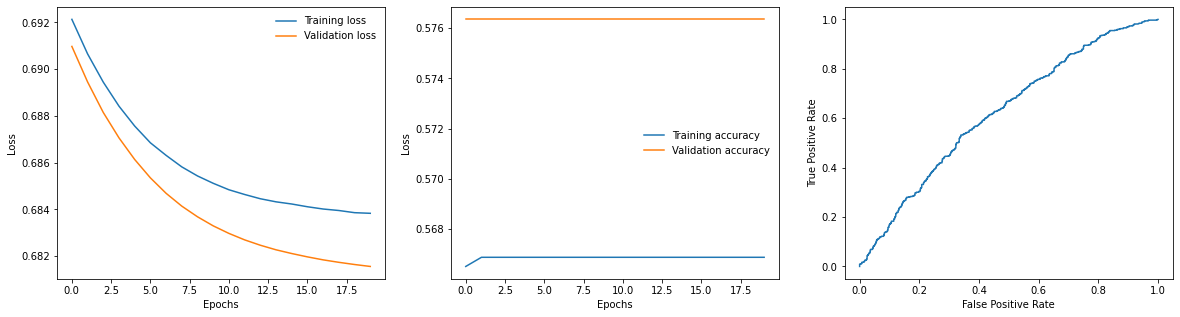

In [78]:
visual_results(base_model,X_test,y_test.values)

As we can SGD optimizer is not dropping F1 score, we will get back to adam optimizer

### Model - 7

trying different learning rate on adam

Reducing learning rate and increasing epochs

In [118]:
# Hyper parameters
dense_layer1 = 1024
dropoutval = 0.5

optimizer = keras.optimizers.Adam(learning_rate=0.000009)

batch_size = 100
epochs = 150


model = Sequential()
model.add(Embedding(len(all_words2),100,input_length=25))
model.add(LSTM(128))
model.add(Activation('relu'))

model.add(Dense(dense_layer1))
model.add(Activation('relu'))
model.add(Dropout(dropoutval))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', patience=5)


base_model = model.fit(X_train,y_train.values, batch_size=batch_size, epochs=epochs,
                       validation_split=0.1,callbacks=[es])

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 25, 100)           1941300   
                                                                 
 lstm_35 (LSTM)              (None, 128)               117248    
                                                                 
 activation_80 (Activation)  (None, 128)               0         
                                                                 
 dense_89 (Dense)            (None, 1024)              132096    
                                                                 
 activation_81 (Activation)  (None, 1024)              0         
                                                                 
 dropout_41 (Dropout)        (None, 1024)              0         
                                                                 
 dense_90 (Dense)            (None, 1)               

2022-06-05 23:13:54.848316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 23:13:55.086137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 23:13:55.422787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5557

2022-06-05 23:13:58.957393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 23:13:59.040560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 8s 69ms/step - loss: 0.6927 - accuracy: 0.5557 - val_loss: 0.6921 - val_accuracy: 0.5764
Epoch 2/150
55/55 [==============================] - 2s 41ms/step - loss: 0.6919 - accuracy: 0.5669 - val_loss: 0.6912 - val_accuracy: 0.5764
Epoch 3/150
55/55 [==============================] - 2s 36ms/step - loss: 0.6909 - accuracy: 0.5669 - val_loss: 0.6901 - val_accuracy: 0.5764
Epoch 4/150
55/55 [==============================] - 2s 34ms/step - loss: 0.6897 - accuracy: 0.5669 - val_loss: 0.6887 - val_accuracy: 0.5764
Epoch 5/150
55/55 [==============================] - 2s 37ms/step - loss: 0.6882 - accuracy: 0.5669 - val_loss: 0.6869 - val_accuracy: 0.5764
Epoch 6/150
55/55 [==============================] - 2s 35ms/step - loss: 0.6863 - accuracy: 0.5669 - val_loss: 0.6844 - val_accuracy: 0.5764
Epoch 7/150
55/55 [==============================] - 2s 43ms/step - loss: 0.6837 - accuracy: 0.5669 - val_loss: 0.6816 - val_accuracy: 0.5764
Epoch 8/150
55/55 

2022-06-05 23:15:38.180616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 23:15:38.246475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 1s 8ms/step
Test loss: 0.5025081634521484 / Test accuracy: 0.7872620224952698 / Test Roc : 0.8390735311820647
F1 Score : 0.7448818897637796


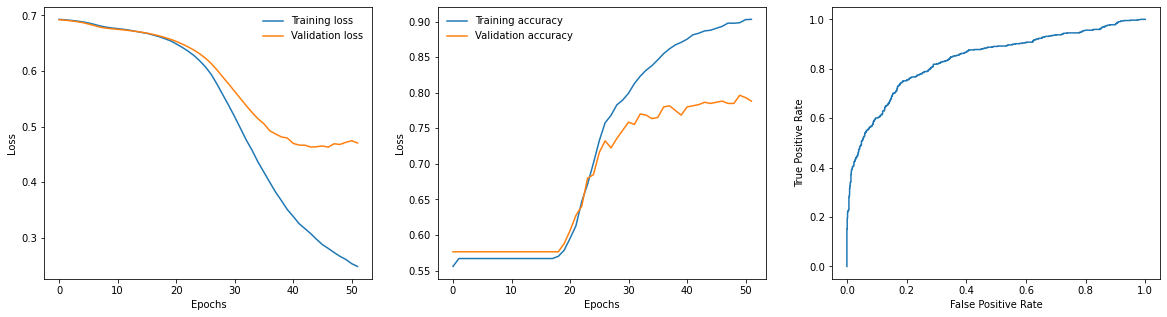

In [119]:
visual_results(base_model,X_test,y_test.values)

# Conclusion

In [108]:
from IPython.display import Image

Below is summary for all the models tried with different architect and hyperparameter tunning

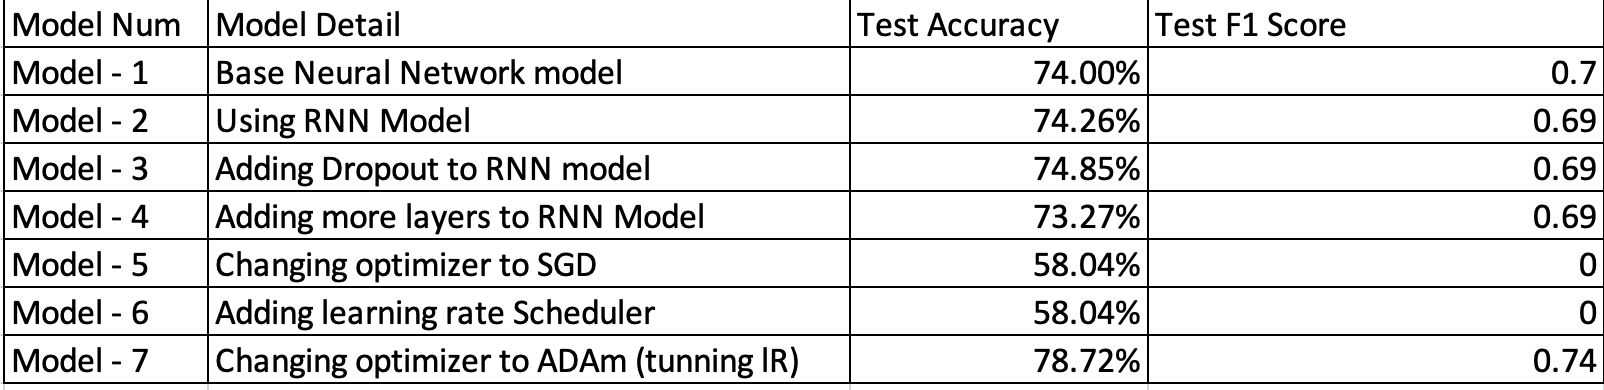

WE got best model F1 score with Adam optimizer.

# Final Submission

In [123]:
y_pred_keras = model.predict_generator(final_test_X, verbose=1)

102/102 [==============================] - 1s 8ms/step


In [163]:
y_prob = pd.DataFrame(y_pred_keras)

In [164]:
y_prob.rename({0 : 'prob'},axis = 1,inplace = True)

In [169]:
sample_df2 = sample_df1.merge(y_prob,left_index = True,right_index=True)

In [171]:
sample_df2.loc[sample_df2.prob>=0.5,'target'] = 1

In [176]:
sample_df2 = sample_df2.drop('prob',axis = 1)

In [179]:
sample_df2.to_csv('/Users/vishalverma/Vishal/Github_project/Twitter-Sentiment-NLP/results/submission.csv',index=False)